In [1]:
import numpy as np
import pandas as pd

np.random.seed(42)

In [2]:
# # Load the store sales dataset
# excel_file = pd.ExcelFile('data/store_sales.xlsx')
# sheet_names = excel_file.sheet_names

# # Read the data
# results_df = pd.read_excel(excel_file, sheet_name=sheet_names[2])  # 2, 9
# iri_key_counts = results_df['IRI_KEY'].value_counts()
# iri_keys = iri_key_counts[iri_key_counts > 300].index


# features = ['F', 'D', 'Unit.Price']
# target = 'Total.Volume'

# results_df = results_df[results_df['IRI_KEY'] == iri_keys[0]]
# X = results_df[features].values
# y = results_df[target].values

# sheet_names, iri_keys, X.shape, y.shape

In [3]:
# # Load the Boston dataset
# data_url = 'http://lib.stat.cmu.edu/datasets/boston'
# raw_df = pd.read_csv(data_url, sep='\s+', skiprows=22,  # type: ignore
#                      header=None)  # type: ignore
# X = np.hstack([raw_df.values[::2, :-1], raw_df.values[1::2, :2]])
# y = raw_df.values[1::2, 2].reshape(-1, 1).ravel()
# X.shape, y.shape

In [4]:
# Load the California housing dataset
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
X = housing.data  # type: ignore
y = housing.target  # type: ignore
X.shape, y.shape, housing.feature_names  # type: ignore

((20640, 8),
 (20640,),
 ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'])

In [5]:
# # Load the soybean dataset
# raw_df = pd.read_excel("data/soybean.xlsx")
# # print(raw_df.head())
# X = raw_df.values[:-1, [5, 6, 15, 16, 17, 26,
#                         34, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]]  # 9 check yield 12 rm band
# y = raw_df.values[:-1, 11]
# X.shape, y.shape

In [6]:
# # Define the data
# data = {
#     "Size": [850, 900, 1200, 1400, 1600, 1700, 1800, 2000, 2200, 2500],
#     "Bedrooms": [2, 3, 3, 3, 3, 4, 4, 4, 5, 5],
#     "Price": [300, 340, 400, 500, 520, 580, 600, 620, 720, 790]
# }

# df = pd.DataFrame(data)

# X = df[["Size", "Bedrooms"]].values
# y = df["Price"].values
# X.shape, y.shape

In [ ]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer

X = X.astype(np.float64)
y = y.astype(np.float64)

scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)
scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()  # type: ignore
# scaler_X = QuantileTransformer()
# X = scaler_X.fit_transform(X)
# scaler_y = QuantileTransformer()
# y = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()  # type: ignore

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from models_sklearn import Ensemble, MLP_sk, FONN1_sk, FONN2_sk, TREENN1_sk, TREENN2_sk
from models import MLP, FONN1, FONN2, TREENN1, TREENN2

search_params = {
    'scoring': ['neg_root_mean_squared_error', 'r2'],
    'n_jobs': -1,
    'refit': 'neg_root_mean_squared_error',
    'cv': 3,
    'verbose': 1,
    'return_train_score': True
}

ensemble_param_grid = {
    'random_state': [42]
}

relu_param_grid = {
    'activation': ['relu'],
    'learning_rate': ['constant'],
    'learning_rate_init': [1e-2],
    'max_iter': [400],
    'random_state': [42],
    'early_stopping': [False],
    'n_iter_no_change': [10000],
}

tanh_param_grid = {
    'activation': ['tanh'],
    'learning_rate': ['adaptive'],
    'learning_rate_init': [1e-2],
    'max_iter': [400],
    'random_state': [42],
    'early_stopping': [False],
    'n_iter_no_change': [10000]
}

random_search_param_grid = {
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': np.logspace(-4, 0, num=100),
    'max_iter': np.arange(100, 2000, 100),
    'random_state': [42],
    'early_stopping': [True, False],
    'n_iter_no_change': [10, 50, 100]
}


def search(model, param_grid=relu_param_grid, search_params=search_params, search_strategy=GridSearchCV):
    return search_strategy(model, param_grid, **search_params)


models = {}

num_trees_input = 5
num_trees_hidden = 5
# hidden_nodes = [5]
# hidden_nodes = [5, 40]
hidden_nodes = [10]
# hidden_nodes = [(5,), (10,), (40,), (100,)]

models['Tree'] = search(Ensemble(1), ensemble_param_grid)
for hn in hidden_nodes:
    if isinstance(hn, tuple):
        models[f'Ensemble {sum(hn)}'] = search(
            Ensemble(sum(hn)), ensemble_param_grid)
        models[f'MLP_sk {hn}'] = search(
            MLP_sk(hn))
        models[f'FONN1_sk {num_trees_input} {hn}'] = search(
            FONN1_sk(num_trees_input, (num_trees_input+hn[0], *hn[1:])))
        models[f'FONN2_sk {num_trees_hidden} {hn}'] = search(
            FONN2_sk(num_trees_hidden, (*hn[:-1], num_trees_hidden+hn[-1])))
        models[f'TREENN1_sk {hn}'] = search(
            TREENN1_sk((1+hn[0], *hn[1:])))
        models[f'TREENN2_sk {hn}'] = search(
            TREENN2_sk((*hn[:-1], 1+hn[-1])))
    else:
        models[f'Ensemble_sk {hn}'] = search(
            Ensemble(hn), ensemble_param_grid)
        models[f'MLP_sk {hn}'] = search(
            MLP_sk(hn))
        models[f'FONN1_sk {num_trees_input} {hn}'] = search(
            FONN1_sk(num_trees_input, num_trees_input+hn))
        models[f'FONN2_sk {num_trees_hidden} {hn}'] = search(
            FONN2_sk(hn, num_trees_hidden+hn))
        models[f'TREENN1_sk {hn}'] = search(
            TREENN1_sk(1+hn))
        models[f'TREENN2_sk {hn}'] = search(
            TREENN2_sk(1+hn))
        models[f'MLP_sk_tanh {hn}'] = search(
            MLP_sk(hn), tanh_param_grid)
        # models[f'FONN1_sk_tanh {num_trees_input} {hn}'] = search_strategy(
        #     FONN1_sk(num_trees_input, num_trees_input+hn), tanh_param_grid)
        # models[f'FONN2_sk_tanh {num_trees_hidden} {hn}'] = search_strategy(
        #     FONN2_sk(hn, num_trees_hidden+hn), tanh_param_grid)
        # models[f'TREENN1_sk_tanh {hn}'] = search_strategy(
        #     TREENN1_sk(1+hn), tanh_param_grid)
        # models[f'TREENN2_sk_tanh {hn}'] = search_strategy(
        #     TREENN2_sk(1+hn), tanh_param_grid)

relu_param_grid = {
    'activation': ['relu'],
    'epochs': [400],
    # 'epochs': [100],
    # 'learning_rate': [1e1, 1e0, 1e-1, 1e-2],
    # 'learning_rate': [1e-2, 1e-3],
    'learning_rate': [1e-2],
}
tanh_param_grid = {
    'activation': ['tanh'],
    'epochs': [400],
    # 'epochs': [100],
    # 'learning_rate': [1e1, 1e0, 1e-1, 1e-2],
    # 'learning_rate': [1e-2, 1e-3],
    'learning_rate': [1e-2],
}

input_dim = X.shape[1]
output_dim = 1

for hn in hidden_nodes:
    models[f'MLP {hn}'] = search(
        MLP(input_dim, hn, output_dim), relu_param_grid)
    models[f'FONN1 {num_trees_input} {hn}'] = search(
        FONN1(input_dim, hn, output_dim, num_trees_input), relu_param_grid)
    models[f'FONN2 {num_trees_hidden} {hn}'] = search(
        FONN2(input_dim, hn, output_dim, num_trees_hidden), relu_param_grid)
    models[f'TREENN1 {hn}'] = search(
        FONN1(input_dim, hn, output_dim, 1), relu_param_grid)
    models[f'TREENN2 {hn}'] = search(
        FONN2(input_dim, hn, output_dim, 1), relu_param_grid)
    models[f'MLP_tanh {hn}'] = search(
        MLP(input_dim, hn, output_dim), tanh_param_grid)
    # models[f'FONN1_tanh {num_trees_input} {hn}'] = search_strategy(
    #     FONN1(input_dim, hn, output_dim, num_trees_input), tanh_param_grid)
    # models[f'FONN2_tanh {num_trees_hidden} {hn}'] = search_strategy(
    #     FONN2(input_dim, hn, output_dim, num_trees_hidden), tanh_param_grid)
    # models[f'TREENN1_tanh {hn}'] = search_strategy(
    #     FONN1(input_dim, hn, output_dim, 1), tanh_param_grid)
    # models[f'TREENN2_tanh {hn}'] = search_strategy(
    #     FONN2(input_dim, hn, output_dim, 1), tanh_param_grid)

    # models['Tree-based Predictions (FONN2)'] = models['FONN2'].trees
    # models['Tree-based Predictions (TREENN2)'] = models['TREENN2'].trees

In [9]:
import sys
import os
from warnings import simplefilter
if not sys.warnoptions:
    simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

# Train and evaluate models
cv_results = {}
results = []

result_columns = [
    'mean_fit_time', 'mean_score_time', 'mean_train_neg_root_mean_squared_error', 'mean_test_neg_root_mean_squared_error', 'mean_train_r2', 'mean_test_r2', 'params'
]

for name, model in models.items():
    model.fit(X, y)
    result = model.cv_results_
    results.append({
        'model': name,
        **{col: result[col][model.best_index_] for col in result_columns if col in result}
    })
    cv_results[name] = result

results_df = pd.DataFrame(results)
results_df.set_index('model', inplace=True)
results_df

Fitting 3 folds for each of 1 candidates, totalling 3 fits


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


,mean_fit_time,mean_score_time,mean_train_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_train_r2,mean_test_r2,params
model,,,,,,,
Tree,0.082474,0.001829,-0.442454,-0.895455,0.852702,0.392939,{'random_state': 42}
Ensemble_sk 10,0.834386,0.008548,-0.215107,-0.702173,0.965185,0.627084,{'random_state': 42}
MLP_sk 10,3.107321,0.002009,-0.873029,-0.902042,0.393655,0.364350,"{'early_stopping': False, 'learning_rate': 'ad..."
FONN1_sk 5 10,3.221898,0.005901,-0.252001,-0.754879,0.952205,0.568874,"{'early_stopping': False, 'learning_rate': 'ad..."
FONN2_sk 5 10,41.662626,0.001969,-15.840118,-16.783729,-204.390900,-223.809187,"{'early_stopping': False, 'learning_rate': 'ad..."
TREENN1_sk 10,2.623208,0.002249,-0.677930,-0.965619,0.573123,0.275607,"{'early_stopping': False, 'learning_rate': 'ad..."
TREENN2_sk 10,6.425420,0.000821,-1.709542,-7.330211,-1.645678,-66.179748,"{'early_stopping': False, 'learning_rate': 'ad..."
MLP_sk_tanh 10,3.452091,0.001385,-1.053084,-1.082307,0.153110,0.100621,"{'activation': 'tanh', 'early_stopping': False..."
MLP 10,2.343030,0.001073,-64.235326,-59.692951,-3666.120765,-2856.123777,"{'activation': 'relu', 'epochs': 400, 'learnin..."


In [ ]:
results_df.sort_values(
    by='mean_test_neg_root_mean_squared_error', ascending=False)

,mean_fit_time,mean_score_time,mean_train_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_train_r2,mean_test_r2,params
model,,,,,,,
Ensemble_sk 10,0.834386,0.008548,-0.215107,-0.702173,0.965185,0.627084,{'random_state': 42}
FONN1_sk 5 10,3.221898,0.005901,-0.252001,-0.754879,0.952205,0.568874,"{'early_stopping': False, 'learning_rate': 'ad..."
Tree,0.082474,0.001829,-0.442454,-0.895455,0.852702,0.392939,{'random_state': 42}
MLP_sk 10,3.107321,0.002009,-0.873029,-0.902042,0.393655,0.364350,"{'early_stopping': False, 'learning_rate': 'ad..."
TREENN1_sk 10,2.623208,0.002249,-0.677930,-0.965619,0.573123,0.275607,"{'early_stopping': False, 'learning_rate': 'ad..."
MLP_tanh 10,3.247544,0.001347,-0.941613,-0.996356,0.330959,0.247457,"{'activation': 'tanh', 'epochs': 400, 'learnin..."
MLP_sk_tanh 10,3.452091,0.001385,-1.053084,-1.082307,0.153110,0.100621,"{'activation': 'tanh', 'early_stopping': False..."
TREENN2_sk 10,6.425420,0.000821,-1.709542,-7.330211,-1.645678,-66.179748,"{'early_stopping': False, 'learning_rate': 'ad..."
FONN2_sk 5 10,41.662626,0.001969,-15.840118,-16.783729,-204.390900,-223.809187,"{'early_stopping': False, 'learning_rate': 'ad..."


In [11]:
results_df.sort_values(by='mean_test_r2', ascending=False)

,mean_fit_time,mean_score_time,mean_train_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_train_r2,mean_test_r2,params
model,,,,,,,
Ensemble_sk 10,0.834386,0.008548,-0.215107,-0.702173,0.965185,0.627084,{'random_state': 42}
FONN1_sk 5 10,3.221898,0.005901,-0.252001,-0.754879,0.952205,0.568874,"{'early_stopping': False, 'learning_rate': 'ad..."
Tree,0.082474,0.001829,-0.442454,-0.895455,0.852702,0.392939,{'random_state': 42}
MLP_sk 10,3.107321,0.002009,-0.873029,-0.902042,0.393655,0.364350,"{'early_stopping': False, 'learning_rate': 'ad..."
TREENN1_sk 10,2.623208,0.002249,-0.677930,-0.965619,0.573123,0.275607,"{'early_stopping': False, 'learning_rate': 'ad..."
MLP_tanh 10,3.247544,0.001347,-0.941613,-0.996356,0.330959,0.247457,"{'activation': 'tanh', 'epochs': 400, 'learnin..."
MLP_sk_tanh 10,3.452091,0.001385,-1.053084,-1.082307,0.153110,0.100621,"{'activation': 'tanh', 'early_stopping': False..."
TREENN2_sk 10,6.425420,0.000821,-1.709542,-7.330211,-1.645678,-66.179748,"{'early_stopping': False, 'learning_rate': 'ad..."
FONN2_sk 5 10,41.662626,0.001969,-15.840118,-16.783729,-204.390900,-223.809187,"{'early_stopping': False, 'learning_rate': 'ad..."


In [12]:
[(result['model'], result['params']) for result in results], cv_results

([('Tree', {'random_state': 42}),
  ('Ensemble_sk 10', {'random_state': 42}),
  ('MLP_sk 10',
   {'early_stopping': False,
    'learning_rate': 'adaptive',
    'learning_rate_init': 0.01,
    'max_iter': 400,
    'n_iter_no_change': 10000,
    'random_state': 42}),
  ('FONN1_sk 5 10',
   {'early_stopping': False,
    'learning_rate': 'adaptive',
    'learning_rate_init': 0.01,
    'max_iter': 400,
    'n_iter_no_change': 10000,
    'random_state': 42}),
  ('FONN2_sk 5 10',
   {'early_stopping': False,
    'learning_rate': 'adaptive',
    'learning_rate_init': 0.01,
    'max_iter': 400,
    'n_iter_no_change': 10000,
    'random_state': 42}),
  ('TREENN1_sk 10',
   {'early_stopping': False,
    'learning_rate': 'adaptive',
    'learning_rate_init': 0.01,
    'max_iter': 400,
    'n_iter_no_change': 10000,
    'random_state': 42}),
  ('TREENN2_sk 10',
   {'early_stopping': False,
    'learning_rate': 'adaptive',
    'learning_rate_init': 0.01,
    'max_iter': 400,
    'n_iter_no_change':

In [ ]:
dataset_rank = results_df[['mean_test_neg_root_mean_squared_error']].rank(
    numeric_only=True, ascending=False)
dataset_rank = dataset_rank.assign(
    Mean=dataset_rank.mean(1), Stddev=dataset_rank.std(1))
dataset_rank

,mean_test_neg_root_mean_squared_error,Mean,Stddev
model,,,
Tree,3.0,3.0,NaN
Ensemble_sk 10,1.0,1.0,NaN
MLP_sk 10,4.0,4.0,NaN
FONN1_sk 5 10,2.0,2.0,NaN
FONN2_sk 5 10,9.0,9.0,NaN
TREENN1_sk 10,5.0,5.0,NaN
TREENN2_sk 10,8.0,8.0,NaN
MLP_sk_tanh 10,7.0,7.0,NaN
MLP 10,10.0,10.0,NaN


In [14]:
# models["MLP 5"].best_estimator_.loss_curve_
# models["MLP 5"].best_estimator_.intercepts_
# models["MLP 5"].best_estimator_.coefs_
# models["MLP 5"].best_estimator_.loss_curve_

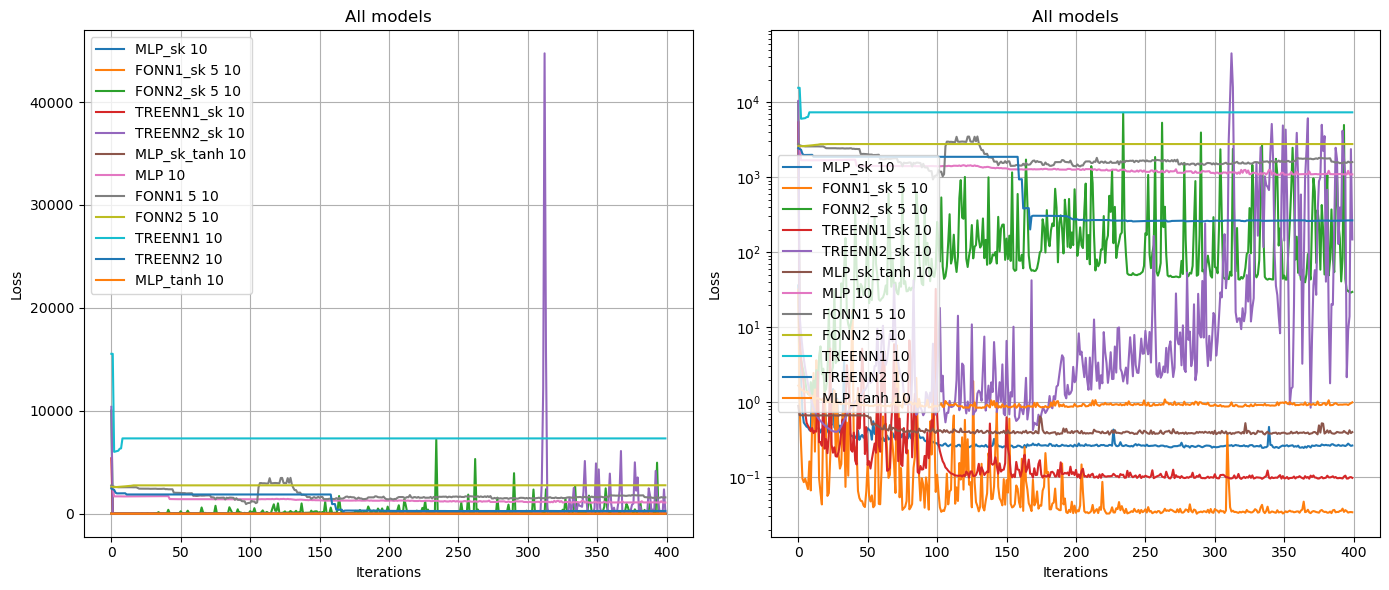

In [15]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for model_name, model in models.items():
    if hasattr(model.best_estimator_, 'loss_curve_'):
        ax1.plot(model.best_estimator_.loss_curve_, label=model_name)
        ax2.plot(model.best_estimator_.loss_curve_, label=model_name)

ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.set_title('All models')
ax1.legend()
ax1.grid(True)

ax2.set_yscale('log')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Loss')
ax2.set_title('All models')
ax2.legend()
ax2.grid(True)

fig.tight_layout()
fig.show()

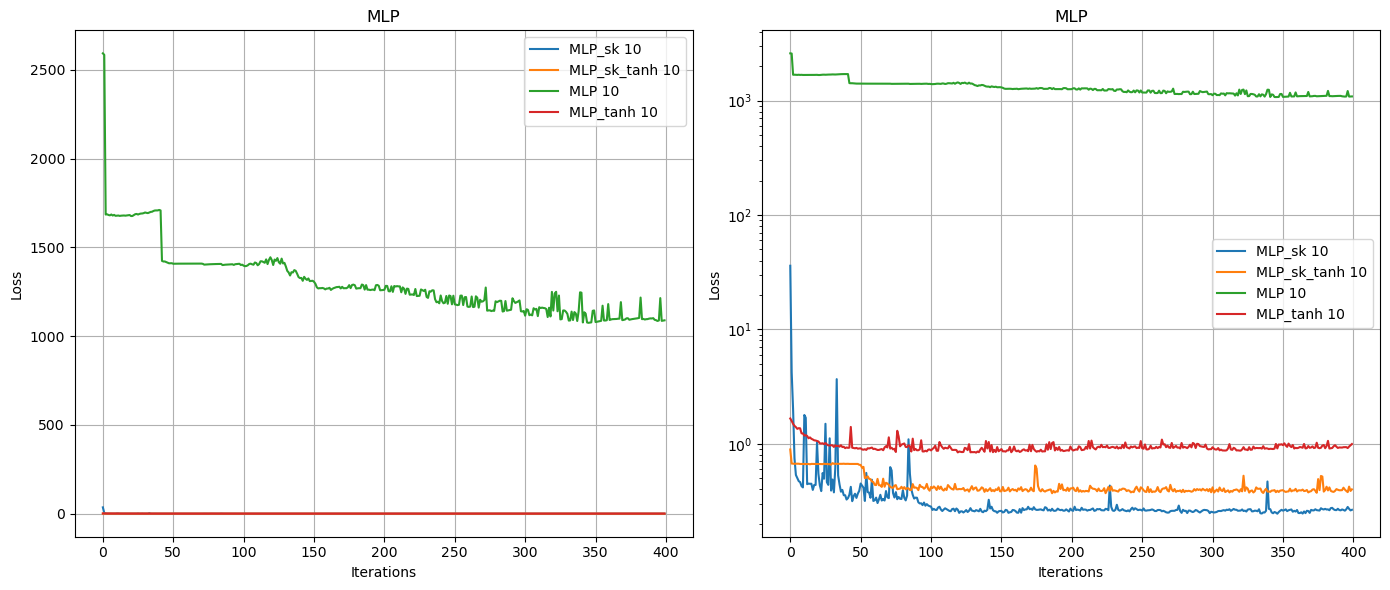

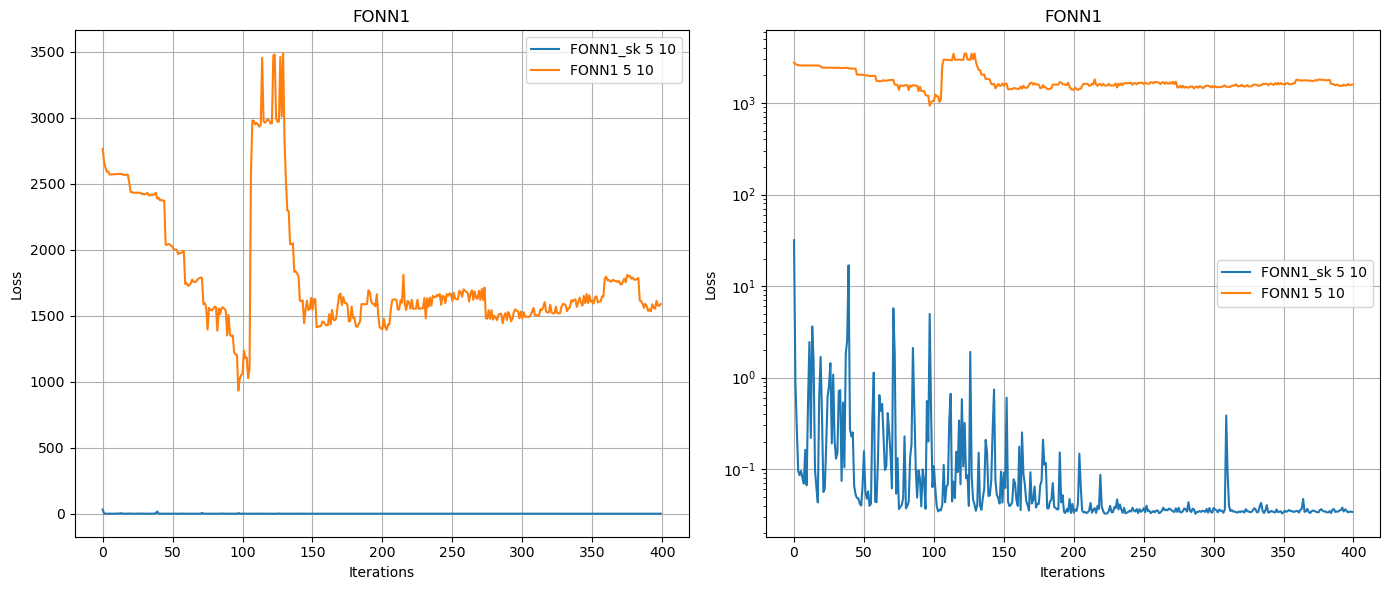

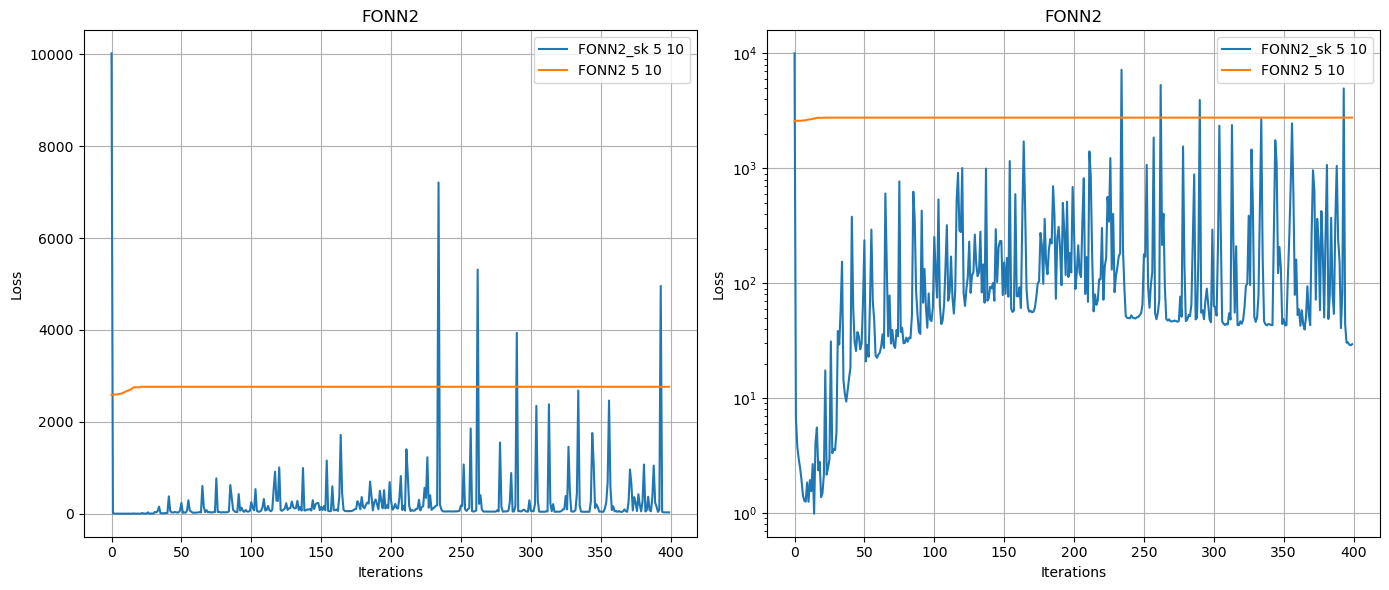

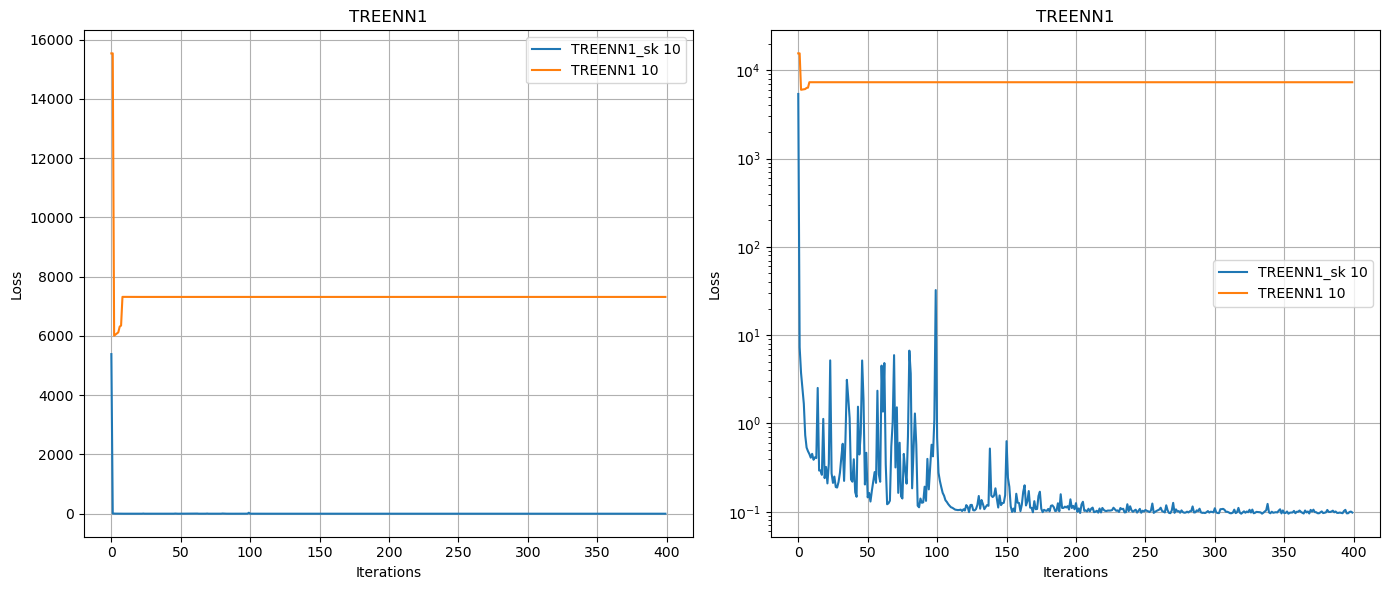

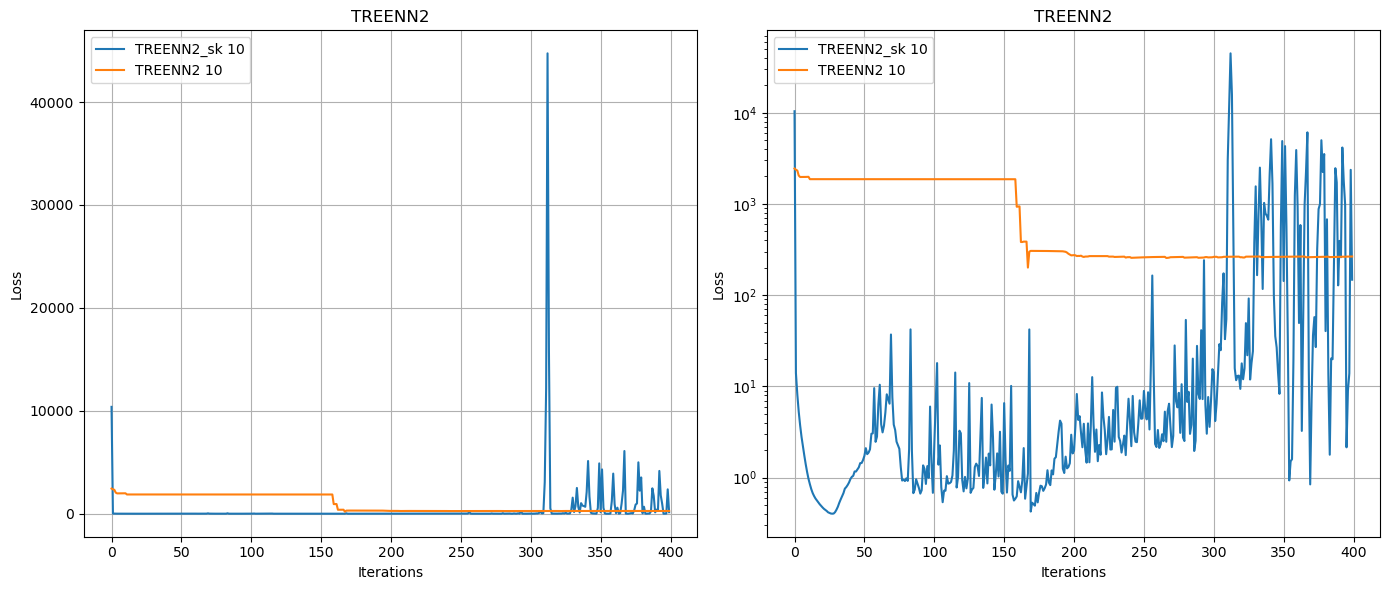

In [16]:
import matplotlib.pyplot as plt

plot_groups = {}
for model_name, model in models.items():
    if hasattr(model.best_estimator_, 'loss_curve_'):
        key = model_name.split('_' if '_' in model_name else ' ')[0]
        if key not in plot_groups:
            plot_groups[key] = plt.subplots(1, 2, figsize=(14, 6))
        fig, (ax1, ax2) = plot_groups[key]
        ax1.plot(model.best_estimator_.loss_curve_, label=model_name)
        ax2.plot(model.best_estimator_.loss_curve_, label=model_name)

for group, plot in plot_groups.items():
    fig, (ax1, ax2) = plot
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')
    ax1.set_title(group)
    ax1.legend()
    ax1.grid(True)

    ax2.set_yscale('log')
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Loss')
    ax2.set_title(group)
    ax2.legend()
    ax2.grid(True)

    fig.tight_layout()
    fig.show()

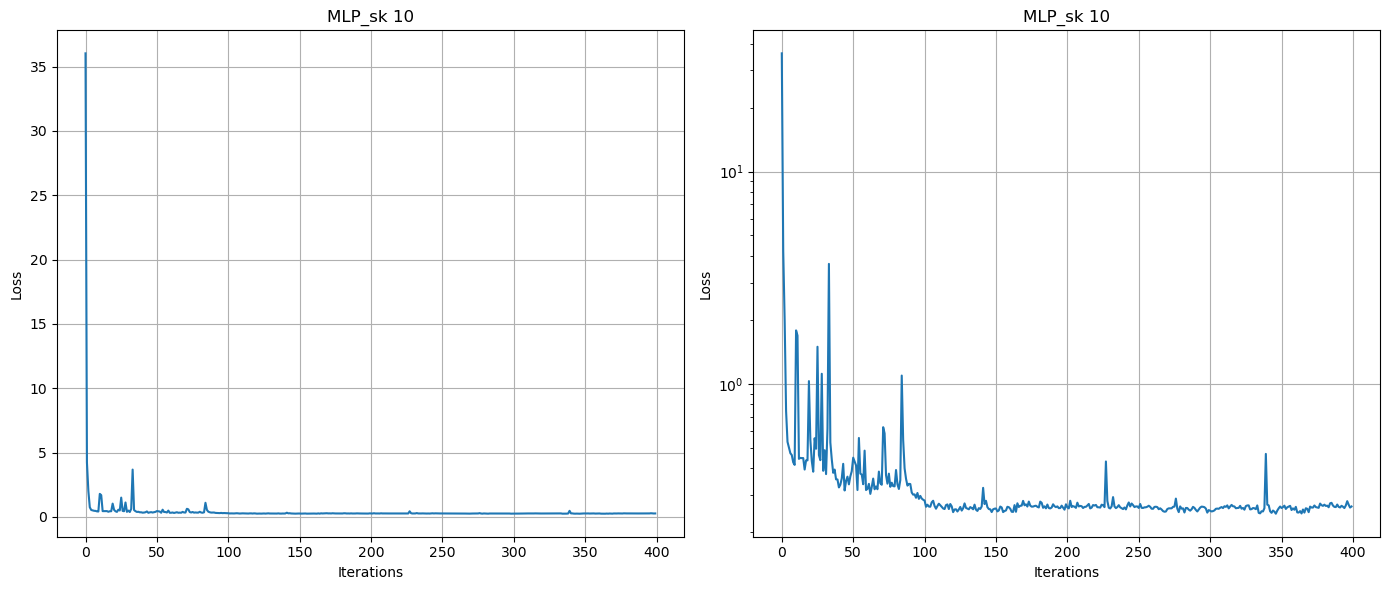

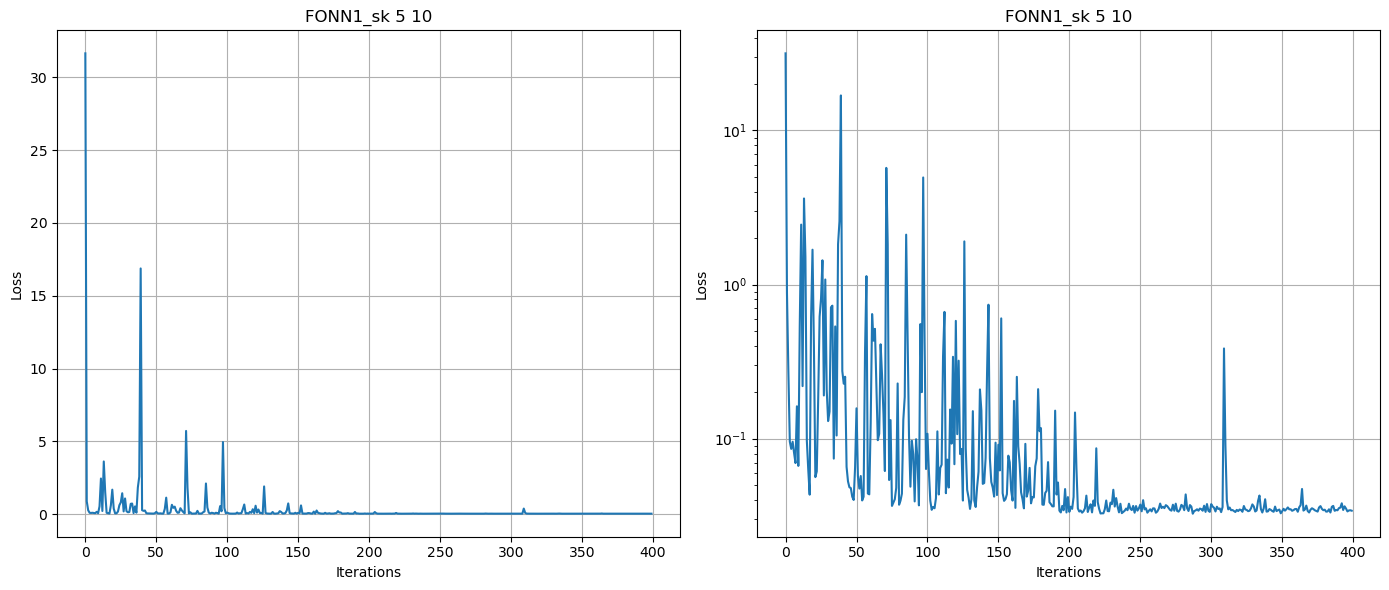

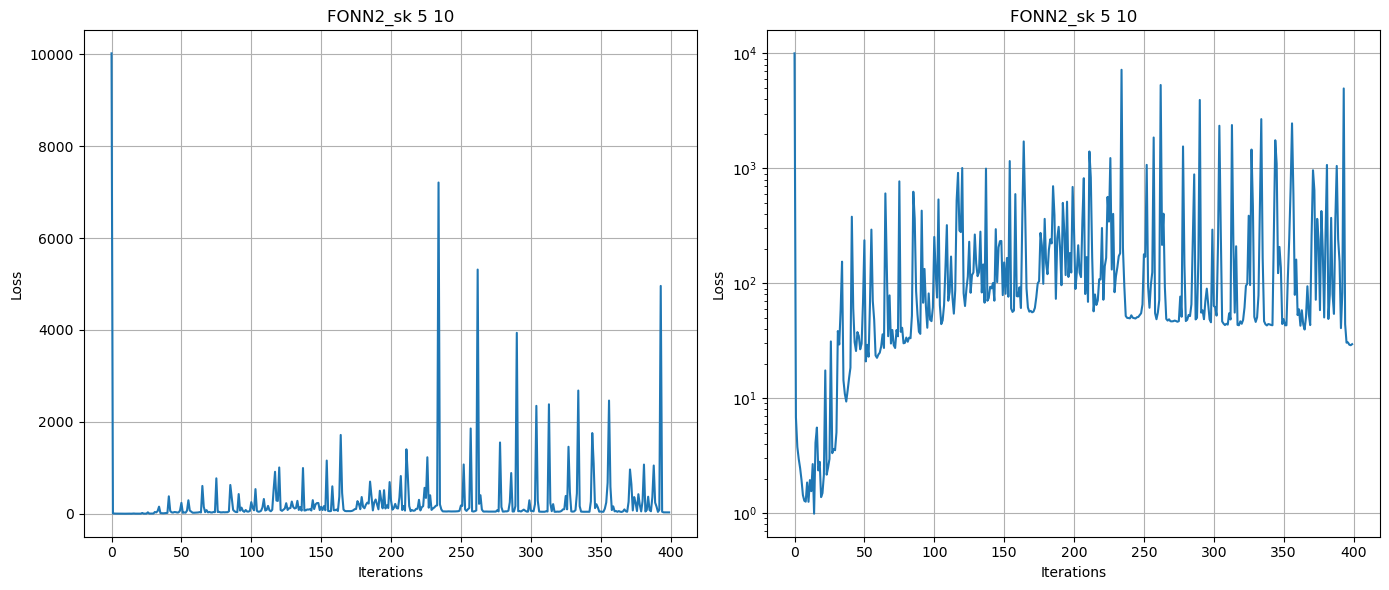

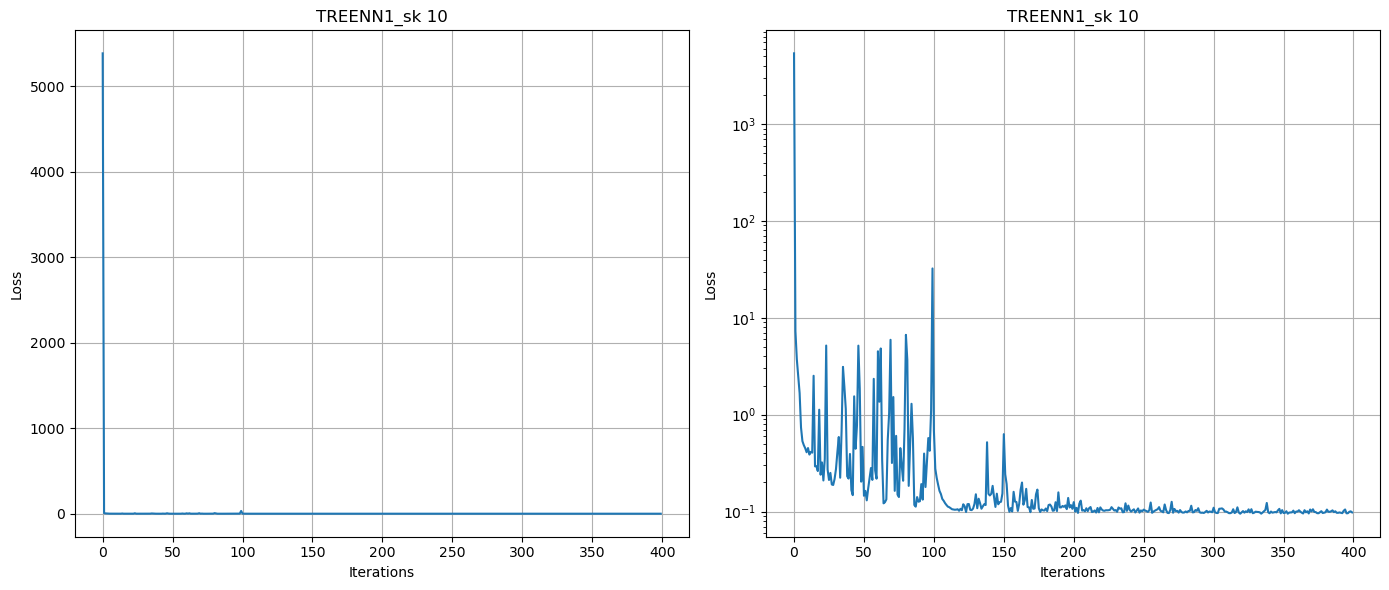

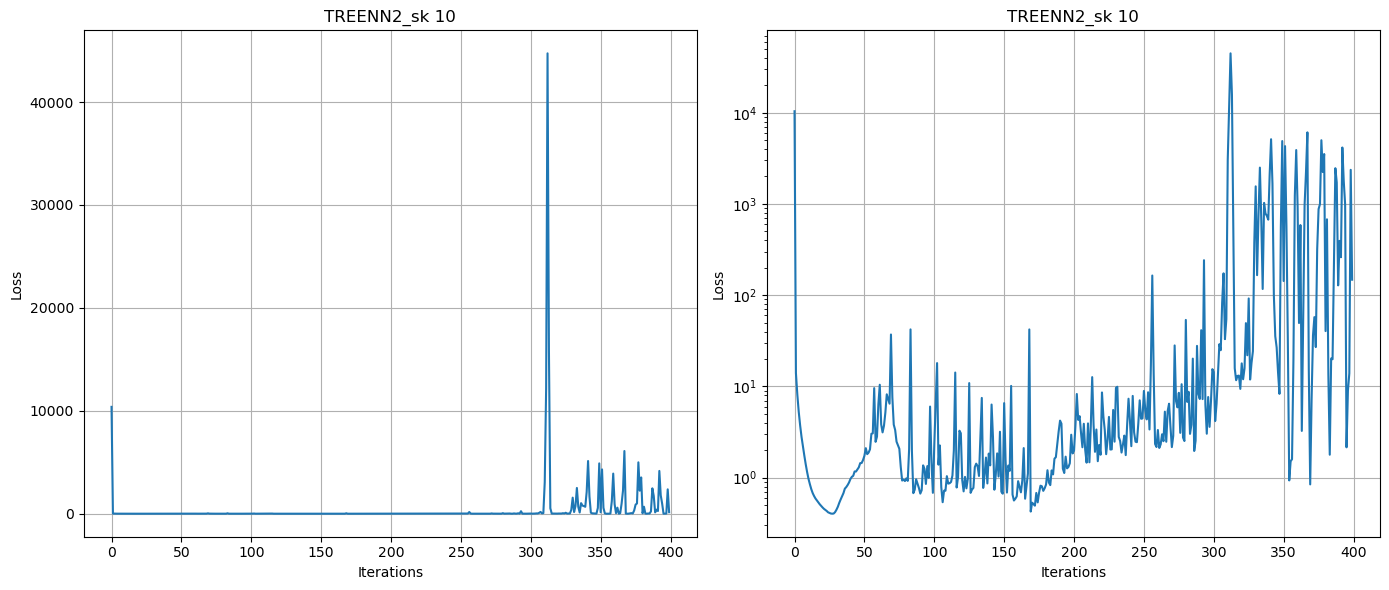

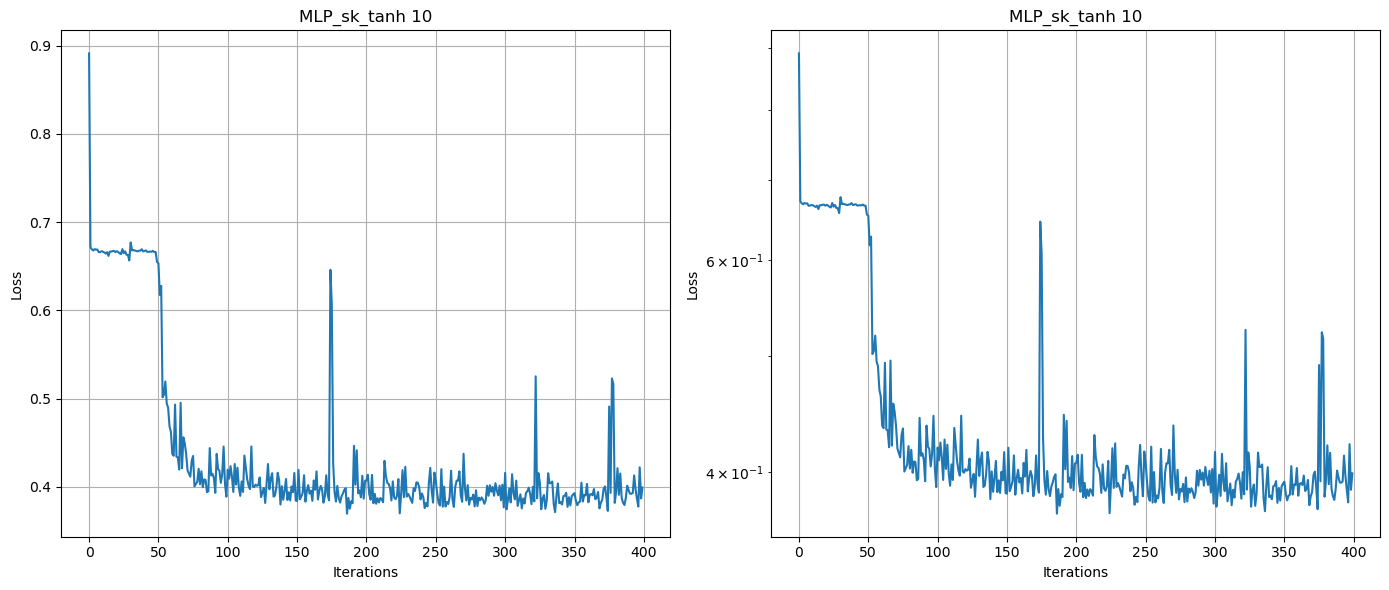

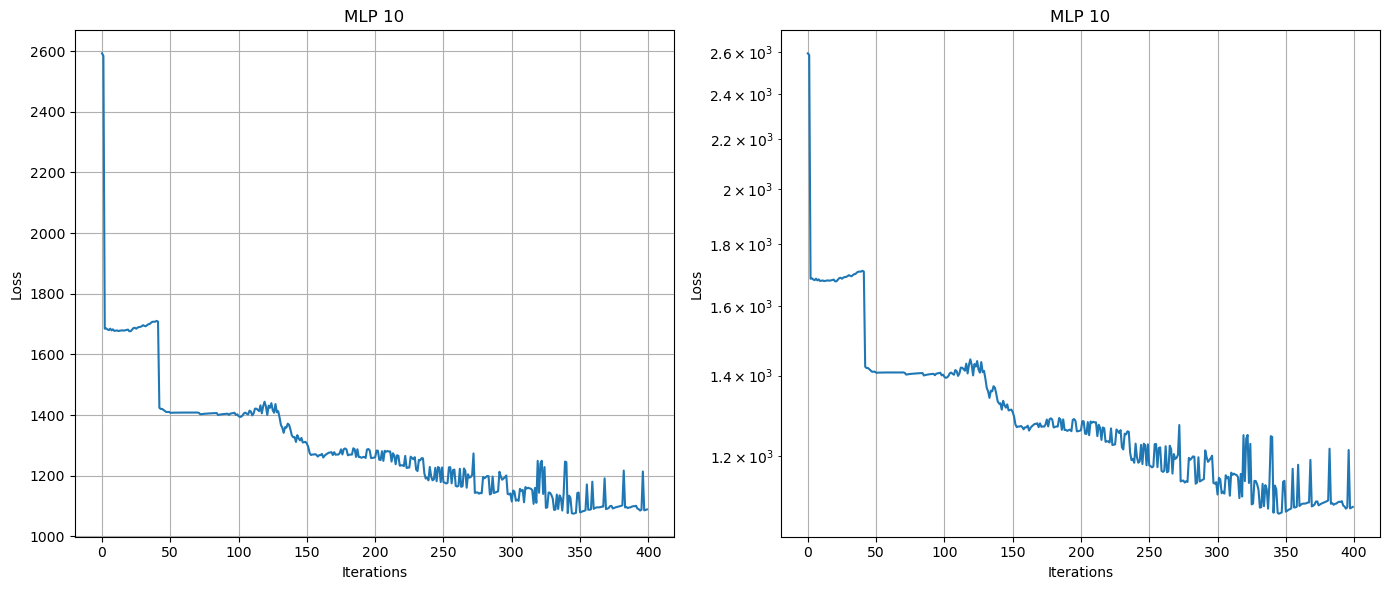

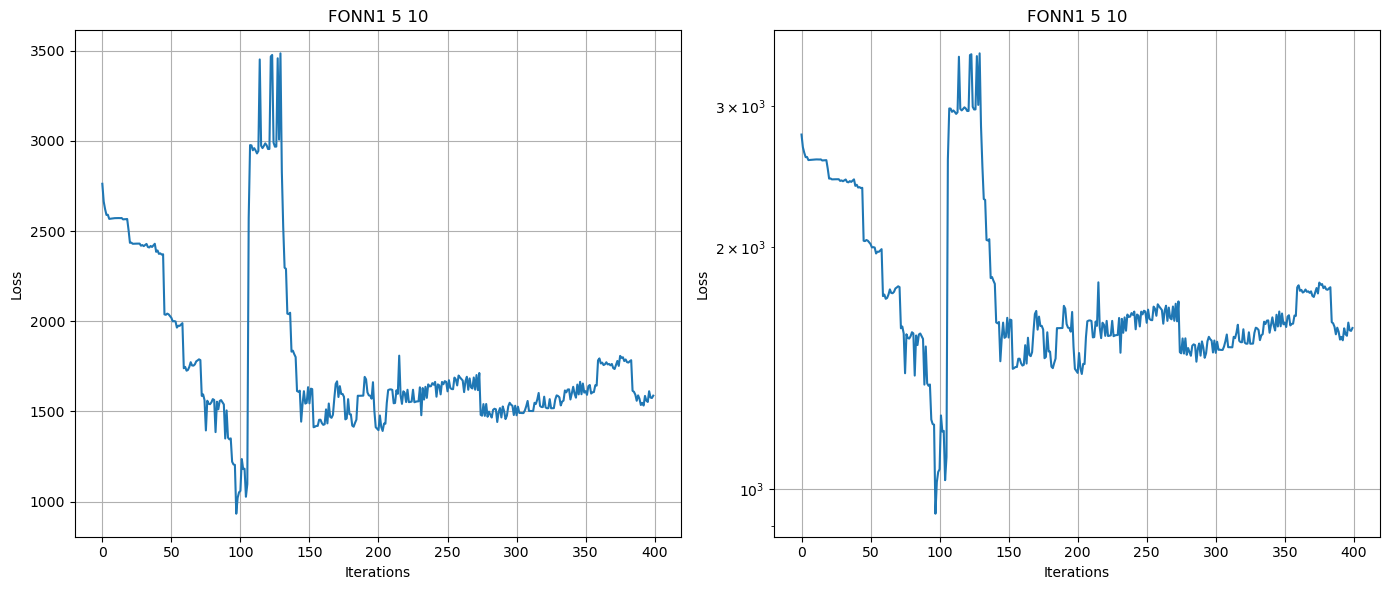

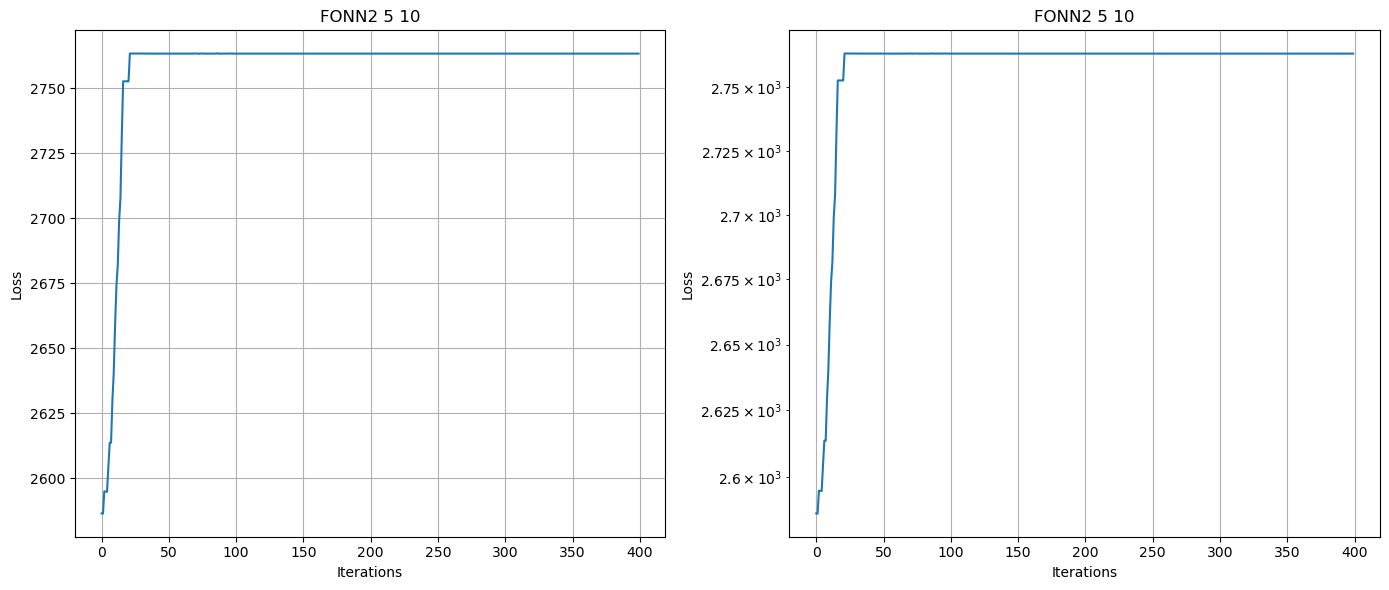

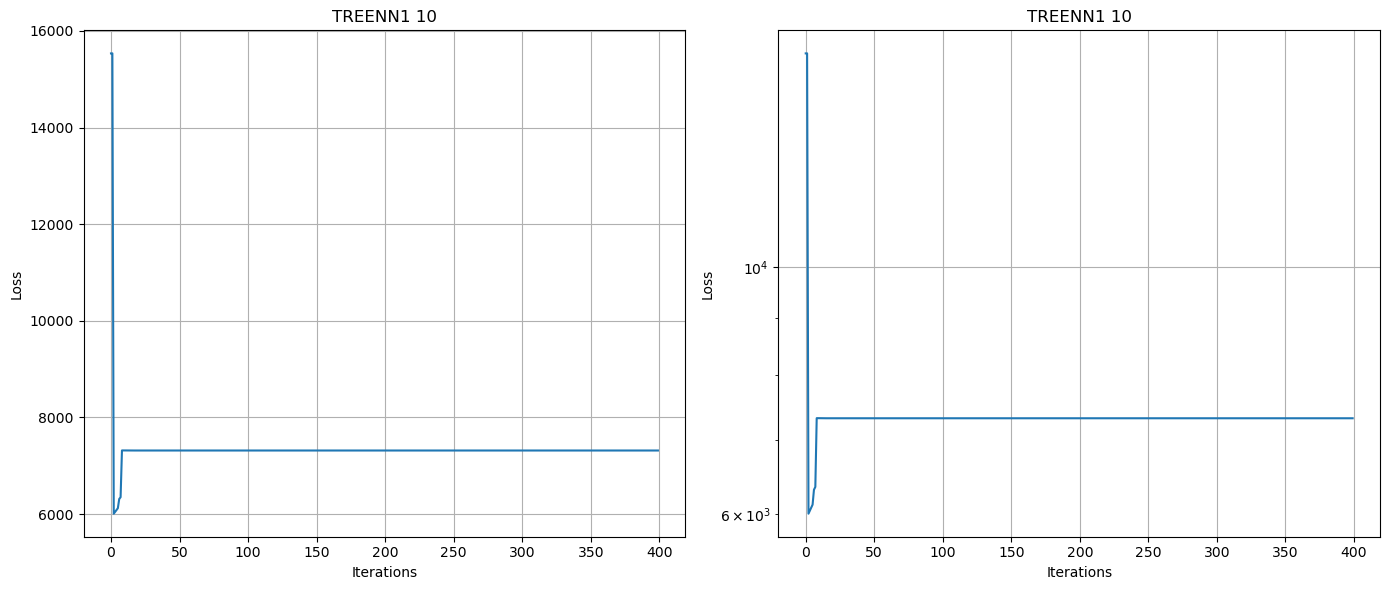

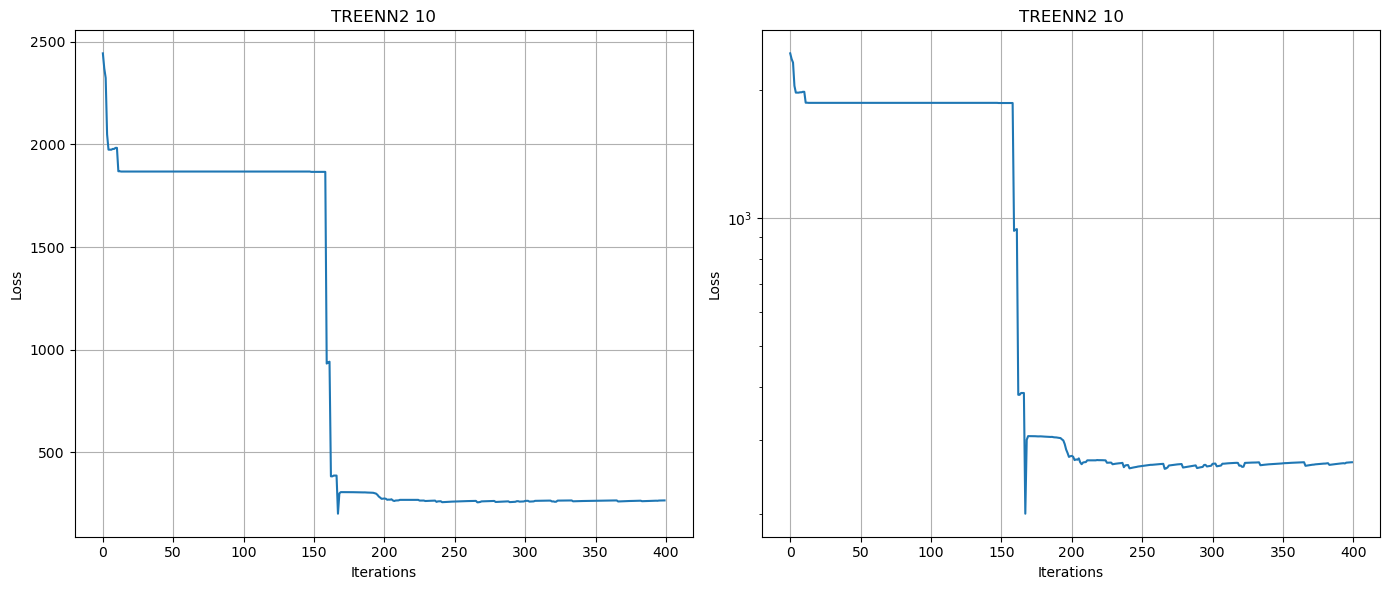

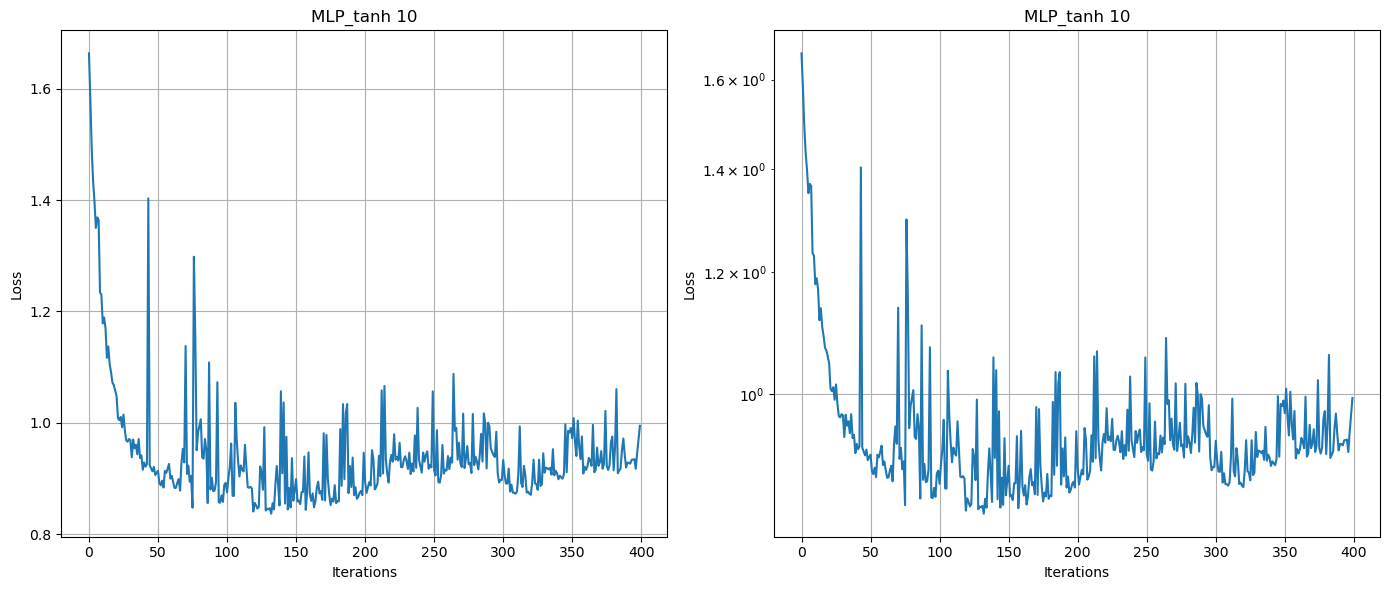

In [17]:
import matplotlib.pyplot as plt


def plot_loss(model, title='Loss Curve'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    ax1.plot(model.loss_curve_)
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')
    ax1.set_title(title)
    ax1.grid(True)

    ax2.plot(model.loss_curve_)
    ax2.set_yscale('log')
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Loss')
    ax2.set_title(title)
    ax2.grid(True)

    fig.tight_layout()
    fig.show()


for model_name, model in models.items():
    if hasattr(model.best_estimator_, 'loss_curve_'):
        plot_loss(model.best_estimator_, model_name)